# Internal exon centered analysis

This notebook allows to compute the main analysis: the internal exon-centered analysis (as described in materials and methods). Three figures are computed here:

* Main text Figure 1, Panel B (upper and lower part)
* Supplementary Figure S2
* Supplementary Figure S3

---

The data required for each plot is saved in a file and loaded before plotting. The reason is that, once the data has been generated, the plot can be created and modified without recomputing the data.

In [1]:
%matplotlib inline

from os import path
import math
import pybedtools
from bgreference import hg19
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.ticker as plticker
import gzip, pickle
import statistics as st

from python_scripts.plot_functions import config_plot_params
config_plot_params()

In [2]:
config_plot_params

<function python_scripts.plot_functions.config_plot_params>

## Input files

Files in **data** directory.

- *middle_exons_coords*: file with the coordinates of the middle exons
- *intron_coords*: file with the coordinates of the introns

Files in **results** directory.

- *kmer_DNM_signatures.txt*: file with the mutational signatures

### Other inputs

- mutations_folder: base directory where the files with the mutations are located
- tumor_type: id of the tumor (germinal in our case)

In [3]:
# Included
intron_coords = 'data/coordinates/genes_intron_coords.bed.gz'
middle_exons_coords = 'data/coordinates/genes_middle_exon_coords.bed.gz'

# Other
mutations_folder = 'non_provided_data/mutations/'
tumor_type = 'germinal'

## Functions

All the functions needed for this notebook are coded below

In [ ]:
def remove_version_ensembl(x, colname):
    """
    Remove version from the ensembl ID

    Args:
        x: dataframe row
        colname: column name

    Returns:
        str. Text before a '.'

    """
    ensembl_id = x[colname]
    ensembl_id_only = ensembl_id.split('.')[0]

    return ensembl_id_only

In [ ]:
def bin_average(count, size):
    averaged = []
    for i in range(0,len(count),size):
        mean = np.mean(count[i:i+size])
        averaged.extend([mean for i in range(len(count[i:i+size]))])
    return(pd.Series(averaged))

In [ ]:
def plot_HD(cluster, ax, cnt):
    
    # read observed and backgruond data directly
    filename = "results/exons_centered_%s.tsv" % (cluster)
    
    if path.isfile(filename):
    
        data = pd.read_csv(filename, sep="\t")
    
        coefs = poly.polyfit(data['position'], data['muts_count'], 50)
        ffit = poly.polyval(data['position'], coefs)

        ax.plot(data['position'],
                 data['muts_count'], '#e41a1c', alpha=0.5, linewidth=0.7)
        ax.plot(data['position'], ffit, '#e41a1c', linewidth=1)

        coefs2 = poly.polyfit(data['position'], data['expected_muts'], 50)
        ffit2 = poly.polyval(data['position'], coefs2)
        ax.plot(data['position'], ffit2, 'black', linewidth=1, ls="--")

        ax.set_axis_bgcolor('none')

        # show the left spline
        for axis in ['right', 'top']:
            ax.spines[axis].set_visible(False)

        # add gap between x- and y-axis
        for axis in ['bottom', 'left']:
            ax.spines[axis].set_position(('axes', -0.03))

        ax.yaxis.major.locator.set_params(nbins=4)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xlim(-1000, 1000)
        # add axis label
        if cnt in [0, 3]:
            ax.set_ylabel('Number of mutations')
        if cnt >=3:
            ax.set_xlabel('Distance from exon center (bp)')

In [ ]:
def plot_HD_BINNED(cluster, ax, cnt, size):
    
    # read observed and backgruond data directly
    filename = "results/exons_centered_%s.tsv" % (cluster)
    
    if path.isfile(filename):
    
        data = pd.read_csv(filename, sep="\t")
        
        bin_obs = bin_average(data['muts_count'], size)

        ax.plot(data['position'],
                 data['muts_count'], '#e41a1c', alpha=0.5, linewidth=0.7)
        ax.plot(data['position'], bin_obs, '#e41a1c', linewidth=1)

        bin_exp = bin_average(data['expected_muts'], size)

        ax.plot(data['position'], bin_exp, 'black', linewidth=1)

        ax.set_axis_bgcolor('none')

        # show the left spline
        for axis in ['right', 'top']:
            ax.spines[axis].set_visible(False)

        # add gap between x- and y-axis
        for axis in ['bottom', 'left']:
            ax.spines[axis].set_position(('axes', -0.03))

        ax.yaxis.major.locator.set_params(nbins=4)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xlim(-1000, 1000)
        # add axis label
        if cnt in [0, 3]:
            ax.set_ylabel('Number of mutations')
        if cnt >=3:
            ax.set_xlabel('Distance from exon center (bp)')

In [8]:
def plot(file, output):

    my_complete_results = pd.read_csv(path.join('results', file), sep="\t")

    config_plot_params()
    fig = plt.figure(figsize=(2.25, 1.9))
    ax = plt.subplot2grid((1, 1), (0, 0))

    # Observed
    coefs = poly.polyfit(my_complete_results['position'], my_complete_results['muts_count'], 50)
    ffit = poly.polyval(my_complete_results['position'], coefs)


    ax.plot(my_complete_results['position'], my_complete_results['muts_count'], '#e41a1c', alpha=0.5, linewidth=1)
    ax.plot(my_complete_results['position'], ffit, '#e41a1c', linewidth=1)

    # Expected
    coefs2 = poly.polyfit(my_complete_results['position'], my_complete_results['expected_muts'], 50)
    ffit2 = poly.polyval(my_complete_results['position'], coefs2)

    ax.plot(my_complete_results['position'], ffit2, 'black', linewidth=1)

    ax.set_facecolor('none')

    # show the left spline
    for axis in ['right', 'top']:
        ax.spines[axis].set_visible(False)

    # add gap between x- and y-axis
    for axis in ['bottom', 'left']:
        ax.spines[axis].set_position(('axes', -0.03))
    
    ax.yaxis.major.locator.set_params(nbins=4)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    ax.set_xlabel('Distance from exon center (bp)')
    ax.set_ylabel('Number of mutations')

    ax.set_xlim(-1000, 1000)
    ax.set_ylim(10, 60)

    ax.set_title("Germline cells (n = 11,237 trios)")

    plt.savefig(path.join('figures', output), bbox_inches='tight')
    plt.show()

In [9]:
def obs_exp_muts_kmer(mutations_df, exon_coords_df, tumor_type, middle_distance_threshold, k, signatures_file):
    """
    Get positions of the exons that correspond to the central position and a number of base pair
    equal to middle_distance_threshold on each side
    Compute the number of mutations per position under analysis.
    For each of the relative positions, compute the sum of the probabilities of each possible alteration
    taking into account its context (using the values of the signatures_file) wheighted by the
    number of observed mutations (MODIFIED FROM FRIGOLA ET AL.).

    Args:

    Returns:
        :class:`~pandas.DataFrame`. Table with the relative position (to the exon center)
        the number of mutations observed and expected in that position.

    """
    nucleotides = set(['A', 'T', 'C', 'G'])
    
    # Get signatures
    all_signatures = pd.read_csv(signatures_file, sep='\t')
    probability_name = 'Probability_' + tumor_type
    sub_signatures_df = all_signatures[['mutation', probability_name]]
    signatures_dict = sub_signatures_df.set_index('mutation').T.to_dict()
    
    # Convert mutations into bed to intersect values
    mutations_bed = pybedtools.BedTool.from_dataframe(mutations_df)

    # Process exonic coordinates to get the 2001-nt region coords and convert into bed
    ## Positions that correspond to the center of the exons
    exon_coords_df['exon_size'] = (exon_coords_df['end'] - exon_coords_df['start'])
    exon_coords_df['exon_middle_start'] = (exon_coords_df['start'] + exon_coords_df['exon_size']/2)
    exon_coords_df['exon_middle_start'] = exon_coords_df.apply(lambda x: math.floor(x['exon_middle_start']), axis=1)
    
    ## Positions around the middle point
    exon_coords_df['exon_middle_end'] = exon_coords_df['exon_middle_start'] + 1
    exon_coords_df['region_start'] = exon_coords_df['exon_middle_start'] - middle_distance_threshold
    exon_coords_df['region_end'] = exon_coords_df['exon_middle_end'] + middle_distance_threshold
    region_coords = exon_coords_df[['chr', 'region_start', 'region_end', 'ensembl',
                                          'exon_size', 'exon_middle_start', 'exon_middle_end', 'start', 'end']]
    region_coords_bed = pybedtools.BedTool.from_dataframe(region_coords)

    # Filter mutations by the full region of interest
    my_bed = region_coords_bed.intersect(mutations_bed, wao=True)

    mutations_in_range = pd.read_table(my_bed.fn, names = ['range_chr', 'range_start', 'range_end',
                        'ensembl','region_size', 'region_middle_start', 'region_middle_end',
                        'exon_start', 'exon_end', 'mut_chr', 'mut_start', 'mut_end', 'mut_ref', 'mut_alt',
                        'mut_sample', 'mut_type', 'mut_ID', 'overlap_bp'],  sep="\s+", index_col=False)
    mutations_in_range = mutations_in_range[mutations_in_range['overlap_bp'] != 0]
    print("The total amount of mutations at the middle exon-centered sequences is " +
          str(len(mutations_in_range.index)))
    
    # Count observed mutations
    ## Create a dictionary of all observed positions at the range of the middle exon-centered window
    mutations_in_range['relative_start'] = mutations_in_range['mut_start'] - mutations_in_range['region_middle_start']
    exon_counts = mutations_in_range['relative_start'].value_counts().to_dict()
    
    ## Set count to 0 were no mutation has been found
    for i in range(-middle_distance_threshold, middle_distance_threshold):
        if i not in exon_counts.keys():
            exon_counts[i] = 0
    
    ## Count mutations for every position with reported counts
    my_exon_results_lol = list()
    for my_position in exon_counts.keys():
        my_count = exon_counts[my_position]
        my_exon_results_lol.append([my_position, my_count])

    my_exon_results_df = pd.DataFrame(my_exon_results_lol)
    my_exon_results_df.columns = ['position', 'muts_count']
    my_exon_results_df = my_exon_results_df.sort_values(by='position')
    
    # For each exonic region under analysis
    # Get its relative position to the center of the exone
    # Add the probability that is the sum of the probabilities of
    final_position_prob_df = pd.DataFrame()
    for my_row in region_coords.values.tolist(): ###FOR EACH EXON, EACH ROW, EACH 2001-nt SEQUENCE
        position_prob_lol = list()
        
        ## Get coordinates
        my_chr = my_row[0]
        my_start = int(my_row[1])
        my_end = int(my_row[2])
        n_bases = my_end - my_start
        
        ## Delimit mutations in the range of that specific middle exon-centered sequence
        my_region_muts = len(mutations_in_range[(mutations_in_range['range_start'] >= my_start) &
                               (mutations_in_range['range_end'] <= my_end) &
                               (mutations_in_range['range_chr'] == my_chr)])
        ## If no mutations are reported for that specific middle exon-centered sequence, skip to the next one.
        if my_region_muts == 0:
            continue
            
        ## If not, get sequence.
        my_exon_bases = hg19(my_chr, my_start+1-(k//2), size=n_bases+2*(k//2))
        ## Divide sequences into kmers
        my_kmers = [my_exon_bases[i:i+k] for i in range(len(my_exon_bases)-(k-1))]
        
        i = 0
        ## Foreach kmer
        for my_kmer in my_kmers:
            my_ref_base = my_kmer[(k//2):(k//2)+1].upper() #Get the reference
            my_alt_bases = nucleotides - set(my_ref_base) #The rest are alternative ones
            my_base_probs = 0
            previous_base = my_kmer[0:(k//2)] #Get previous and next base
            next_base = my_kmer[(k//2)+1:]
            
            ### Foreach alternative, each of the three possible changes given a kmer.
            for alt_base in my_alt_bases:
                #### Built reference and alternate kmers
                tri_ref = previous_base + str(my_ref_base) + next_base
                tri_alt = previous_base + str(alt_base) + next_base
                #### Create key for the signature dictionary
                my_key = str((tri_ref, tri_alt))
                try:
                    ##### Add the probability of the three possible changes
                    my_prob = signatures_dict[my_key]['Probability_' + tumor_type]
                    my_base_probs = my_base_probs + my_prob
                except:
                    None
            
            ### Add the position in the 2001-nt window with the correspondent probability to a list
            normalized_i = i - middle_distance_threshold
            my_row = [normalized_i, my_base_probs]
            position_prob_lol.append(my_row)
            i += 1
        
        ## Convert the list to a dataframe
        position_prob_df = pd.DataFrame(position_prob_lol)
        position_prob_df.columns = ['position', 'probability']
        
        ## Reescaling probabilities to one
        my_total = sum(position_prob_df['probability'])
        position_prob_df['probability'] = position_prob_df['probability']/my_total
        
        ## Compute the expected by redistributing the total number of mutations in the 2001-nt 
        ## sequence according to the probabilities
        position_prob_df['expected_muts'] = position_prob_df['probability']*my_region_muts
        position_prob_df = position_prob_df[['position', 'expected_muts']]
        
        # Sum the expected results
        if len(final_position_prob_df) == 0:
            final_position_prob_df = position_prob_df
        else:
            final_position_prob_df['expected_muts'] = (final_position_prob_df['expected_muts'] +
                                                       position_prob_df['expected_muts'])
    
    return pd.merge(my_exon_results_df, final_position_prob_df, on='position')

In [ ]:
def obs_exp_muts_kmer_CCDS(mutations_df, exon_coords_df, tumor_type, middle_distance_threshold, k, signatures_file):
    """
    Get positions of the exons that correspond to the central position and a number of base pair
    equal to middle_distance_threshold on each side
    Compute the number of mutations per position under analysis.
    For each of the relative positions, compute the sum of the probabilities of each possible alteration
    taking into account its context (using the values of the signatures_file) wheighted by the
    number of observed mutations (MODIFIED FROM FRIGOLA ET AL.).

    Args:

    Returns:
        :class:`~pandas.DataFrame`. Table with the relative position (to the exon center)
        the number of mutations observed and expected in that position.

    """
    nucleotides = set(['A', 'T', 'C', 'G'])
    
    # Get signatures
    all_signatures = pd.read_csv(signatures_file, sep='\t')
    probability_name = 'Probability_' + tumor_type
    sub_signatures_df = all_signatures[['mutation', probability_name]]
    signatures_dict = sub_signatures_df.set_index('mutation').T.to_dict()
    
    # Convert mutations into bed to intersect values
    mutations_bed = pybedtools.BedTool.from_dataframe(mutations_df)

    # Process exonic coordinates to get the 2001-nt region coords and convert into bed
    ## Positions that correspond to the center of the exons
    exon_coords_df['exon_size'] = (exon_coords_df['end'] - exon_coords_df['start'])
    exon_coords_df['exon_middle_start'] = (exon_coords_df['start'] + exon_coords_df['exon_size']/2)
    exon_coords_df['exon_middle_start'] = exon_coords_df.apply(lambda x: math.floor(x['exon_middle_start']), axis=1)
    
    ## Positions around the middle point
    exon_coords_df['exon_middle_end'] = exon_coords_df['exon_middle_start'] + 1
    exon_coords_df['region_start'] = exon_coords_df['exon_middle_start'] - middle_distance_threshold
    exon_coords_df['region_end'] = exon_coords_df['exon_middle_end'] + middle_distance_threshold
    region_coords = exon_coords_df[['chr', 'region_start', 'region_end', 'ensembl',
                                          'exon_size', 'exon_middle_start', 'exon_middle_end', 'start', 'end', 'strand']]
    region_coords_bed = pybedtools.BedTool.from_dataframe(region_coords)

    # Filter mutations by the full region of interest
    my_bed = region_coords_bed.intersect(mutations_bed, wao=True)

    mutations_in_range = pd.read_table(my_bed.fn, names = ['range_chr', 'range_start', 'range_end',
                        'ensembl','region_size', 'region_middle_start', 'region_middle_end',
                        'exon_start', 'exon_end', 'exon_strand', 'mut_chr', 'mut_start', 'mut_end', 'mut_ref', 'mut_alt',
                        'mut_sample', 'mut_type', 'mut_ID', 'overlap_bp'],  sep="\s+", index_col=False)
    mutations_in_range = mutations_in_range[mutations_in_range['overlap_bp'] != 0]
    print("The total amount of mutations at the middle exon-centered sequences is " +
          str(len(mutations_in_range.index)))
    
    # Count observed mutations
    ## Create a dictionary of all observed positions at the range of the middle exon-centered window
    mutations_in_range['relative_start'] = mutations_in_range['mut_start'] - mutations_in_range['region_middle_start']
    exon_counts = mutations_in_range['relative_start'].value_counts().to_dict()
    
    ## Set count to 0 were no mutation has been found
    for i in range(-middle_distance_threshold, middle_distance_threshold):
        if i not in exon_counts.keys():
            exon_counts[i] = 0
    
    ## Count mutations for every position with reported counts
    my_exon_results_lol = list()
    for my_position in exon_counts.keys():
        my_count = exon_counts[my_position]
        my_exon_results_lol.append([my_position, my_count])

    my_exon_results_df = pd.DataFrame(my_exon_results_lol)
    my_exon_results_df.columns = ['position', 'muts_count']
    my_exon_results_df = my_exon_results_df.sort_values(by='position')
    
    # For each exonic region under analysis
    # Get its relative position to the center of the exone
    # Add the probability that is the sum of the probabilities of
    final_position_prob_df = pd.DataFrame()
    for my_row in region_coords.values.tolist(): ###FOR EACH EXON, EACH ROW, EACH 2001-nt SEQUENCE
        position_prob_lol = list()
        
        ## Get coordinates
        my_chr = my_row[0]
        my_start = int(my_row[1])
        my_end = int(my_row[2])
        n_bases = my_end - my_start
        my_strand = str(my_coord[9])
        
        ## Delimit mutations in the range of that specific middle exon-centered sequence
        my_region_muts = len(mutations_in_range[(mutations_in_range['range_start'] >= my_start) &
                               (mutations_in_range['range_end'] <= my_end) &
                               (mutations_in_range['range_chr'] == my_chr)])
        ## If no mutations are reported for that specific middle exon-centered sequence, skip to the next one.
        if my_region_muts == 0:
            continue
            
        ## If not, get sequence.
        my_exon_bases = hg19(my_chr, my_start+1-(k//2), size=n_bases+2*(k//2))
                ## Check strand, now is taken into account reverse complementary:
        if my_strand == '-':
            my_exon_bases = rev_comp(my_exon_bases)
        
        ## Divide sequences into kmers
        my_kmers = [my_exon_bases[i:i+k] for i in range(len(my_exon_bases)-(k-1))]
        
        ## Now is taken into account reverse complementary:
        if my_strand == '+':
            i = 0
            for my_kmer in my_kmers:
                my_core = my_kmer[(k//2)-(h//2):(k//2)+(h//2)+1].upper() #Get the reference
                my_base_probs = decomp_prob(k, mut_matrixes[cores_dict[my_core]],
                                        kmer_matrixes[cores_dict[my_core]], my_kmer, h)
                    
            
                ### Add the position in the 2001-nt window with the correspondent probability to a list
                normalized_i = i - middle_distance_threshold
                my_row = [normalized_i, my_base_probs]
                position_prob_lol.append(my_row)
                i += 1
                
                
        else:
            i = middle_distance_threshold*2
            for my_kmer in my_kmers:
                my_core = my_kmer[(k//2)-(h//2):(k//2)+(h//2)+1].upper() #Get the reference
                my_base_probs = decomp_prob(k, mut_matrixes[cores_dict[my_core]],
                                        kmer_matrixes[cores_dict[my_core]], my_kmer, h)
                    
            
                ### Add the position in the 2001-nt window with the correspondent probability to a list
                normalized_i = i - middle_distance_threshold
                my_row = [normalized_i, my_base_probs]
                position_prob_lol.append(my_row)
                i -= 1
        
        ## Convert the list to a dataframe
        position_prob_df = pd.DataFrame(position_prob_lol)
        position_prob_df.columns = ['position', 'probability']
        
        ## Reescaling probabilities to one
        my_total = sum(position_prob_df['probability'])
        position_prob_df['probability'] = position_prob_df['probability']/my_total
        
        ## Compute the expected by redistributing the total number of mutations in the 2001-nt 
        ## sequence according to the probabilities
        position_prob_df['expected_muts'] = position_prob_df['probability']*my_region_muts
        position_prob_df = position_prob_df[['position', 'expected_muts']]
        
        ## Before summing expected, we need to rearrange order so reverse complementary positions work
        if my_strand == '-':
            position_prob_df = position_prob_df.sort_values('position', ascending=True)
        
        # Sum the expected results
        if len(final_position_prob_df) == 0:
            final_position_prob_df = position_prob_df
        else:
            final_position_prob_df['expected_muts'] = (final_position_prob_df['expected_muts'] +
                                                       position_prob_df['expected_muts'])
    
    return pd.merge(my_exon_results_df, final_position_prob_df, on='position')

In [ ]:
def stacked_sequence_level_permutation(mutations_df, exons_coords_symbol_df, signatures_file, tumor_type,
                                       middle_distance_threshold, k):
    """
    Get the co-ordinates of exons and flanking intronic sequences and perform the random sampling of mutations
    (1000 times) with the size equal of the number of mutation observed in the 2001-nt window (exon and intron
    together).
    
    Args:
        
    Returns:
        

    """
    
    nucleotides = set(['A', 'T', 'C', 'G'])
    
    # Get signatures
    all_signatures = pd.read_csv(signatures_file, sep='\t')
    probability_name = 'Probability_' + tumor_type
    sub_signatures_df = all_signatures[['mutation', probability_name]]
    signatures_dict = sub_signatures_df.set_index('mutation').T.to_dict()
    
    # Create bed of the selected mutations
    sub_mutations_df = mutations_df[['chr', 'start', 'end', 'sample']]
    mutations_bed = pybedtools.BedTool.from_dataframe(sub_mutations_df)
    
    exons_coords_symbol_df['exon_size'] = (exons_coords_symbol_df['end'] - exons_coords_symbol_df['start'])
    exons_coords_symbol_df['exon_middle_start'] = (exons_coords_symbol_df['start'] +
                                        exons_coords_symbol_df['exon_size']/2)
    exons_coords_symbol_df['exon_middle_start'] = exons_coords_symbol_df.apply(lambda x:
                                        math.floor(x['exon_middle_start']), axis=1)

    exons_coords_symbol_df['exon_middle_end'] = exons_coords_symbol_df['exon_middle_start'] + 1
    exons_coords_symbol_df['region_start'] = exons_coords_symbol_df['exon_middle_start'] - middle_distance_threshold
    exons_coords_symbol_df['region_end'] = exons_coords_symbol_df['exon_middle_end'] + middle_distance_threshold
    
    # Left flank "intronic" sequences => region_start and start froom coordinates.
    intron1_df = exons_coords_symbol_df[['chr', 'region_start', 'start', 'ID']]
    ## The region may span less than the centered exonic sequence. Only take left flank intronic coordinates with sense.
    intron1_df = intron1_df[intron1_df['region_start'] <= intron1_df['start']]
    intron1_df.columns = ['chr', 'start', 'end', 'ID']
    
    # Right flank "intronic" sequences
    intron2_df = exons_coords_symbol_df[['chr', 'end', 'region_end', 'ID']]
    ## The region may span less than the centered exonic sequence. Only take right flank intronic coordinates with sense.
    intron2_df = intron2_df[intron2_df['end'] <= intron2_df['region_end']]
    intron2_df.columns = ['chr', 'start', 'end', 'ID']
    ## Take them together
    intron_df = pd.concat([intron1_df, intron2_df])
    intron_df['label'] = 'intron'

    # Exonic sequences
    all_exon_df = exons_coords_symbol_df[['chr', 'start', 'end', 'ID', 'region_start', 'region_end']]
    ## The region may span less than the centered exonic sequence. Process exons that surpass the region size.
    large_exon_df = all_exon_df[(all_exon_df['end']-all_exon_df['start']) > (2*middle_distance_threshold+1)]
    large_exon_df = large_exon_df[['chr', 'region_start', 'region_end', 'ID']]
    large_exon_df.columns = ['chr', 'start', 'end', 'ID']
    ## The region may span less than the centered exonic sequence. Process exons that do not surpass the region size.
    short_exon_df = all_exon_df[(all_exon_df['end']-all_exon_df['start']) <= (2*middle_distance_threshold+1)]
    short_exon_df = short_exon_df[['chr', 'start', 'end', 'ID']]
    short_exon_df.columns = ['chr', 'start', 'end', 'ID']
    ## Take them together
    exon_df = pd.concat([short_exon_df, large_exon_df])
    exon_df['label'] = 'exon'
    
    # Merge exons and introns
    coords_symbol_df = pd.concat([exon_df, intron_df])
    coords_symbol_bed = pybedtools.BedTool.from_dataframe(coords_symbol_df)

    # Filter mutations by the position of interest
    my_bed = coords_symbol_bed.intersect(mutations_bed, wo=True)

    mutations_mapped = pd.read_table(my_bed.fn, names = ['chr', 'start', 'end', 'ID','label', 'mut_chr',
                                    'mut_start', 'mut_end', 'sample', 'overlap_bp'],  sep="\s+", index_col=False)
    
    print("Total amount of mutations at the middle exon-centered sequences is "+ str(len(mutations_mapped)))
    exonic_obs = mutations_mapped[mutations_mapped['label'] == 'exon'].shape[0]
    intronic_obs = mutations_mapped[mutations_mapped['label'] == 'intron'].shape[0]
    print("Observed at middle exons: " + str(exonic_obs))
    print("Observed at flanking introns: " + str(intronic_obs))
    
    # Compute expected mutation by randomization approach
    RANDOMIZATION = 1000

    collect_rand = {}
    # Initialize dictionary
    for sam in range(0, RANDOMIZATION):
        collect_rand[sam] = {}
        collect_rand[sam]['exon_Exp'] = 0
        collect_rand[sam]['intron_Exp'] = 0

    # For each unique staked exon-centered sequence with one or more mutations
    for gene in mutations_mapped['ID'].unique():
        position_prob_lol = list()
        label_flag_lol = list()
        
        # Take the exonic and the flanking intronic sequences.
        for dx, row in coords_symbol_df[coords_symbol_df['ID']==gene].iterrows():
            my_chr = row['chr'][3:]
            my_start = int(row['start'])
            my_end = int(row['end'])
            n_bases = my_end - my_start

            ## Get sequence.
            my_exon_bases = hg19(my_chr, my_start+1-(k//2), size=n_bases+2*(k//2))
            ## Divide sequences into kmers
            my_kmers = [my_exon_bases[i:i+k] for i in range(len(my_exon_bases)-(k-1))]
            
            label_flag = 0 # to mark intron vs exon
            if row['label']=='exon':
                label_flag = 1 

            ## Foreach kmer
            for my_kmer in my_kmers:
                my_ref_base = my_kmer[(k//2):(k//2)+1].upper() #Get the reference
                my_alt_bases = nucleotides - set(my_ref_base) #The rest are alternative ones
                my_base_probs = 0
                previous_base = my_kmer[0:(k//2)] #Get previous and next base
                next_base = my_kmer[(k//2)+1:]
            
                ### Foreach alternative, each of the three possible changes given a kmer.
                for alt_base in my_alt_bases:
                    #### Built reference and alternate kmers
                    tri_ref = previous_base + str(my_ref_base) + next_base
                    tri_alt = previous_base + str(alt_base) + next_base
                    #### Create key for the signature dictionary
                    my_key = str((tri_ref, tri_alt))
                    try:
                        ##### Add the probability of the three possible changes
                        my_prob = signatures_dict[my_key]['Probability_' + tumor_type]
                        my_base_probs = my_base_probs + my_prob
                    except:
                        None      
                
                position_prob_lol.append(my_base_probs)
                label_flag_lol.append(label_flag)
            
        # Total number of mutations falling in the stacked sequence.
        mutcnt = len(mutations_mapped[mutations_mapped['ID']==gene])
        # Normalize the probability vector and perform sampling
        prb_vector = np.array(position_prob_lol)
        prb_vector = prb_vector/prb_vector.sum()
        label_vector = np.array(label_flag_lol)
        mutation_rand_label = np.random.choice(label_vector, size=mutcnt*RANDOMIZATION, replace=True, p=prb_vector)
        
        # Save the mutation count for each randomization
        for sam in range(0, RANDOMIZATION):
            start = int(mutcnt*sam)
            # count for one random sampling
            count = np.unique(mutation_rand_label[start:(start+mutcnt)], return_counts=True)
            for i in range(0, len(count[0])):
                if count[0][i] == 1: # count of exons
                    collect_rand[sam]['exon_Exp'] += count[1][i]
                else: # count of introns
                    collect_rand[sam]['intron_Exp'] += count[1][i]
        
    collect_df = pd.DataFrame.from_dict(collect_rand)
    
    return(collect_df, exonic_obs, intronic_obs)

## Load data

In [10]:
## Get exon coordinates
exons_coords_df = pd.read_csv(middle_exons_coords, sep="\t", header=None, low_memory=False)
exons_coords_df.columns = ['chr', 'start', 'end', 'ensembl', 'symbol', 'strand']
exons_coords_df = exons_coords_df[['chr', 'start', 'end', 'ensembl']]
exons_coords_df['ensembl'] = exons_coords_df.apply(lambda x: remove_version_ensembl(x, 'ensembl'), axis=1)
exons_coords_df.columns = ['chr', 'start', 'end', 'ensembl']

## Get mutations
mutations_file = mutations_folder + 'germinal_ultimate_dataset.bed.gz'
mutations_df = pd.read_csv(mutations_file, sep="\t", header=None)
mutations_df.columns = ['chr', 'start', 'end', 'ref', 'alt', 'sample', 'type', 'class']
mutations_df = mutations_df[['chr', 'start', 'end', 'ref', 'alt', 'sample', 'type']]
mutations_df = mutations_df[mutations_df['type'] == 'subs']
mutations_df['ID'] = mutations_df.index + 1

## Exons centered analysis, WG signatures: Figure 1, panel B (upper part)

Following the method described in the **Exon-centered and intron-centered mutational analyses** section, for each exonic position around the center, we computed the observed and expected number of mutations.

In [11]:
k = 3
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_new.txt'

exons_centered_results = obs_exp_muts_kmer(mutations_df, exons_coords_df, tumor_type, 
                                           middle_distance_threshold, k, signatures_file)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer.tsv', sep="\t", header=True, index=False)

KeyboardInterrupt: 

/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: The fit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel_launcher.py:18: RankWarning: The fit may be poorly conditioned
/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


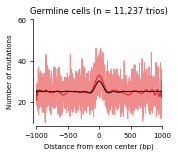

In [12]:
plot('exons_centered_3mer.tsv', "Internal_exon_centered.svg")

### Plot results

Binned average approach. Bin size is 25.

In [ ]:
size = 25

listt = ['3mer']

NROW=1
NCOL=1

axs = []

fig = plt.figure(figsize=(7,4))

for row in range(0, NROW):
    for col in range(0, NCOL):
        axs.append(plt.subplot2grid((NROW, NCOL), (row, col)))

cnt=0
for ele in listt:
    plot_HD_BINNED(ele, axs[cnt], cnt, size)
    cnt+=1
    
plt.tight_layout()
plt.savefig(path.join('figures', 'internal_exon_centered_binned_HD.svg'), bbox_inches='tight')
plt.show()

### Plot results

Polynomial fit approach.

/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: The fit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel_launcher.py:17: RankWarning: The fit may be poorly conditioned
/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


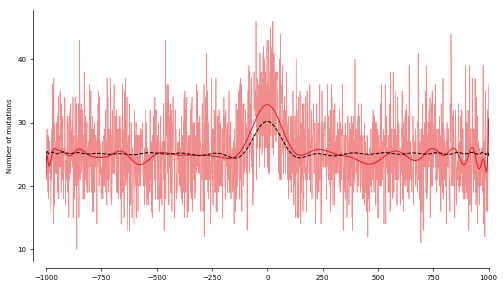

In [14]:
listt = ['3mer']

NROW=1
NCOL=1

axs = []

fig = plt.figure(figsize=(7,4))

for row in range(0, NROW):
    for col in range(0, NCOL):
        axs.append(plt.subplot2grid((NROW, NCOL), (row, col)))

cnt=0
for ele in listt:
    plot_HD(ele, axs[cnt], cnt)
    cnt+=1
    
    
plt.tight_layout()
plt.savefig(path.join('figures', 'internal_exon_centered_HD.svg'), bbox_inches='tight')
plt.show()

## Exon intron proportion: Figure 1, panel B, (lower part)

Compute the ratio of exons to introns in the positions under analysis. It is expected that in the center all base pairs belong to exons.

In [ ]:
middle_distance_threshold = 1000

# Load coordinates files
exons_coords_df = pd.read_csv(middle_exons_coords, sep="\t", header=None, low_memory=False)
exons_coords_df.columns = ['chr', 'start', 'end', 'ensembl', 'symbol', 'strand']
exons_coords_df = exons_coords_df[['chr', 'start', 'end', 'ensembl']]
exons_coords_df['ensembl'] = exons_coords_df.apply(lambda x: remove_version_ensembl(x, 'ensembl'), axis=1)
exons_coords_df.columns = ['chr', 'start', 'end', 'ensembl']
exons_coords_symbol_df = exons_coords_df[['chr', 'start', 'end', 'ensembl']]

introns_coords_df = pd.read_csv(intron_coords, sep="\t", header=None, low_memory=False)
introns_coords_df.columns = ['chr', 'start', 'end', 'ensembl', 'symbol', 'strand']
introns_coords_df = introns_coords_df[['chr', 'start', 'end', 'ensembl']]
introns_coords_df['ensembl'] = introns_coords_df.apply(lambda x: remove_version_ensembl(x, 'ensembl'), axis=1)
introns_coords_df.columns = ['chr', 'start', 'end', 'ensembl']
introns_coords_symbol_df = introns_coords_df[['chr', 'start', 'end', 'ensembl']]

# Get the positions of interest (center of the exons and a number of bp around)
exons_coords_symbol_df['exon_size'] = (exons_coords_symbol_df['end'] - exons_coords_symbol_df['start'])
exons_coords_symbol_df['exon_middle_start'] = (exons_coords_symbol_df['start'] + exons_coords_symbol_df['exon_size'] / 2)
exons_coords_symbol_df['exon_middle_start'] = exons_coords_symbol_df.apply(lambda x:
                                                                           math.floor(x['exon_middle_start']),
                                                                           axis=1)
exons_coords_symbol_df['exon_middle_end'] = exons_coords_symbol_df['exon_middle_start'] + 1
exons_coords_symbol_df['region_start'] = exons_coords_symbol_df['exon_middle_start'] - middle_distance_threshold
exons_coords_symbol_df['region_end'] = exons_coords_symbol_df['exon_middle_end'] + middle_distance_threshold

sub_exons_coords = exons_coords_symbol_df[['chr', 'region_start', 'region_end', 'ensembl',
                                           'exon_size', 'exon_middle_start',
                                           'exon_middle_end']]

region_coords_bed = pybedtools.BedTool.from_dataframe(sub_exons_coords)
exons_coords_bed = pybedtools.BedTool.from_dataframe(exons_coords_symbol_df[['chr', 'start', 'end']])
introns_coords_bed = pybedtools.BedTool.from_dataframe(introns_coords_symbol_df[['chr', 'start', 'end']])

# Intersect the coordinates with the exons and introns
region_exons_bed = region_coords_bed.intersect(exons_coords_bed, wao=True)
region_introns_bed = region_coords_bed.intersect(introns_coords_bed, wao=True)

exons_in_range = pd.read_table(region_exons_bed.fn, names=['range_chr', 'range_start', 'range_end',
                                                           'ensembl', 'region_size', 'region_middle_start',
                                                           'region_middle_end',
                                                           'region_chr', 'region_start', 'region_end', 'overlap_bp'])

introns_in_range = pd.read_table(region_introns_bed.fn, names=['range_chr', 'range_start', 'range_end',
                                                               'ensembl', 'region_size', 'region_middle_start',
                                                               'region_middle_end',
                                                               'region_chr', 'region_start', 'region_end',
                                                               'overlap_bp'])

exons_in_range['real_overlap_start'] = exons_in_range[["range_start", "region_start"]].max(axis=1)
exons_in_range['real_overlap_end'] = exons_in_range[["range_end", "region_end"]].min(axis=1)

introns_in_range['real_overlap_start'] = introns_in_range[["range_start", "region_start"]].max(axis=1)
introns_in_range['real_overlap_end'] = introns_in_range[["range_end", "region_end"]].min(axis=1)

exons_in_range['relative_start'] = exons_in_range['real_overlap_start'] - exons_in_range['region_middle_start']
exons_in_range['relative_end'] = exons_in_range['real_overlap_end'] - exons_in_range['region_middle_start'] + 1

introns_in_range['relative_start'] = introns_in_range['real_overlap_start'] - introns_in_range['region_middle_start']
introns_in_range['relative_end'] = introns_in_range['real_overlap_end'] - introns_in_range['region_middle_start'] + 1

exons_per_base_dict = dict()
introns_per_base_dict = dict()

for index, my_exon in exons_in_range.iterrows():
    my_start = my_exon.relative_start
    my_end = my_exon.relative_end

    for i in range(my_start, my_end):
        if i not in exons_per_base_dict.keys():
            exons_per_base_dict[i] = 1
        else:
            exons_per_base_dict[i] += 1

for index, my_intron in introns_in_range.iterrows():
    my_start = my_intron.relative_start
    my_end = my_intron.relative_end

    for i in range(my_start, my_end):
        if i not in introns_per_base_dict.keys():
            introns_per_base_dict[i] = 1
        else:
            introns_per_base_dict[i] += 1

my_rates_to_plot = list()

for my_key in exons_per_base_dict.keys():
    n_exon_muts = int(exons_per_base_dict[my_key])
    n_intron_muts = int(introns_per_base_dict[my_key])

    exon_intron_proportion = n_exon_muts / (n_intron_muts + n_exon_muts) * 100
    my_rates_to_plot.append([my_key, exon_intron_proportion])

my_rates_to_plot_df = pd.DataFrame(my_rates_to_plot)
my_rates_to_plot_df.columns = ['position', 'exon_intron_percentage']

my_rates_to_plot_df = my_rates_to_plot_df.sort_values(by='position', ascending=True)

my_rates_to_plot_df.to_csv(path.join('results', 'exon_intron_proportion.tsv'), sep='\t', index=False)

### Plot the distribution of the ratio

Distribution of the proportion of exonic bases at each postion across the window.

In [ ]:
my_rates_to_plot_df = pd.read_csv(path.join('results', 'exon_intron_proportion.tsv'), sep='\t')

fig = plt.figure(figsize=(2.25, 0.5))
ax = plt.subplot2grid((1, 1), (0, 0))

ax.margins(0.05)  # Optional, just adds 5% padding to the autoscaling

ax.plot(my_rates_to_plot_df['position'], my_rates_to_plot_df['exon_intron_percentage'], lw=1)
ax.set_xlim(-1000,1000)

# show the left spline
for axis in ['right', 'top']:
    ax.spines[axis].set_visible(False)

for axis in ['bottom', 'left']:
    ax.spines[axis].set_position(('axes', -0.03))
    
ax.yaxis.major.locator.set_params(nbins=5)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')



ax.set_xlabel('Distance from exon center (bp)')
ax.set_ylabel('Exon (%)')


plt.savefig(path.join('figures', 'Proportion_internal_exon_centered.svg'), bbox_inches='tight')
plt.show()

## Internal exon centered analysis, blacklisted regions: Supplementary figure S2

In [ ]:
middle_distance_threshold = 1000

# Process exonic coordinates to get the 2001-nt region coords and
## Positions that correspond to the center of the exons
exon_coords_df['exon_size'] = (exon_coords_df['end'] - exon_coords_df['start'])
exon_coords_df['exon_middle_start'] = (exon_coords_df['start'] + exon_coords_df['exon_size']/2)
exon_coords_df['exon_middle_start'] = exon_coords_df.apply(lambda x: math.floor(x['exon_middle_start']), axis=1)
    
## Positions around the middle point
exon_coords_df['exon_middle_end'] = exon_coords_df['exon_middle_start'] + 1
exon_coords_df['region_start'] = exon_coords_df['exon_middle_start'] - middle_distance_threshold
exon_coords_df['region_end'] = exon_coords_df['exon_middle_end'] + middle_distance_threshold
region_coords = exon_coords_df[['chr', 'region_start', 'region_end', 'ensembl',
                                          'exon_size', 'exon_middle_start', 'exon_middle_end', 'start', 'end', 'ID']]
regions_bp = sum(region_coords['region_end'] - region_coords['region_start'])
print(regions_bp)
region_coords_bed = pybedtools.BedTool.from_dataframe(region_coords)

### Filtering

#### Individual blacklisted

In [ ]:
# Filter blacklisted regions
ucsc_blacklisted_df = pd.read_csv(ucsc_blacklisted_file, sep='\t', header=None)

ucsc_blacklisted_bed = pybedtools.BedTool.from_dataframe(ucsc_blacklisted_df)

region_coords_black = region_coords_bed.subtract(ucsc_blacklisted_bed)

region_coords_black_df = pd.read_table(region_coords_black.fn, names=['chr', 'region_start', 'region_end', 'ensembl',
                                          'exon_size', 'exon_middle_start', 'exon_middle_end', 'start', 'end', 'ID'])

regions_bp_black = sum(region_coords_black_df['region_end'] - region_coords_black_df['region_start'])

print('+ blacklisted regions:\t', 100-regions_bp_black/regions_bp*100)

# Select all duplicate rows based on one column
IDs_to_remove_black = region_coords_black_df[region_coords_black_df.duplicated(['ID'])]['ID']
(len(IDs_to_remove_black.unique())/95633)*100

#### Individual low complexity regions

In [ ]:
# Filter low complexity regions
low_complexity_df = pd.read_csv(low_complexity_file, sep='\t', header=None)

low_complexity_bed = pybedtools.BedTool.from_dataframe(low_complexity_df)

region_coords_compl = region_coords_bed.subtract(low_complexity_bed)

region_coords_compl_df = pd.read_table(region_coords_compl.fn, names=['chr', 'region_start', 'region_end', 'ensembl',
                                          'exon_size', 'exon_middle_start', 'exon_middle_end', 'start', 'end', 'ID'])

regions_bp_compl = sum(region_coords_compl_df['region_end'] - region_coords_compl_df['region_start'])

print('+ low complexity:\t', 100-regions_bp_compl/regions_bp*100)

# Select all duplicate rows based on one column
IDs_to_remove_compl = region_coords_compl_df[region_coords_compl_df.duplicated(['ID'])]['ID']
(len(IDs_to_remove_compl.unique())/95633)*100

#### Intersection

In [ ]:
# Filter blacklisted regions
ucsc_blacklisted_df = pd.read_csv(ucsc_blacklisted_file, sep='\t', header=None)

ucsc_blacklisted_bed = pybedtools.BedTool.from_dataframe(ucsc_blacklisted_df)

region_coords_black_df = pd.read_table(region_coords_black.fn, names=['chr', 'region_start', 'region_end', 'ensembl',
                                          'exon_size', 'exon_middle_start', 'exon_middle_end', 'start', 'end', 'ID'])

# Filter low complexity regions
low_complexity_df = pd.read_csv(low_complexity_file, sep='\t', header=None)

low_complexity_bed = pybedtools.BedTool.from_dataframe(low_complexity_df)

region_coords_black_bed = pybedtools.BedTool.from_dataframe(region_coords_black_df)

region_coords_ALL = region_coords_black_bed.subtract(low_complexity_bed)

region_coords_ALL_df = pd.read_table(region_coords_ALL.fn, names=['chr', 'region_start', 'region_end', 'ensembl',
                                          'exon_size', 'exon_middle_start', 'exon_middle_end', 'start', 'end', 'ID'])

regions_bp_ALL = sum(region_coords_ALL_df['region_end'] - region_coords_ALL_df['region_start'])

print('+ together:\t', 100-regions_bp_ALL/regions_bp*100)

# Select all duplicate rows based on one column
IDs_to_remove_ALL = region_coords_ALL_df[region_coords_ALL_df.duplicated(['ID'])]['ID']
(len(IDs_to_remove_ALL.unique())/95633)*100

#### Apply filter

In [ ]:
# Filter middle exons
exons_coords_df = exon_coords_df.loc[~exon_coords_df['ID'].isin(IDs_to_remove_ALL)]
exons_coords_df = exons_coords_df[['chr', 'start', 'end', 'ensembl']]

### Exons centered analysis on high mappability regions: WG signatures

In [ ]:
k = 3
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_new.txt'

exons_centered_results = obs_exp_muts_kmer(mutations_df, exons_coords_df, tumor_type, 
                                           middle_distance_threshold, k, signatures_file)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_BLACKLISTED.tsv', sep="\t", header=True, index=False)

In [ ]:
plot('exons_centered_3mer_BLACKLISTED.tsv', "Internal_exon_centered_BLACKLISTED.svg")

### Plot results

Binned average approach. Bin size is 25.

In [ ]:
size = 25

listt = ['3mer_BLACKLISTED']

NROW=1
NCOL=1

axs = []

fig = plt.figure(figsize=(7,4))

for row in range(0, NROW):
    for col in range(0, NCOL):
        axs.append(plt.subplot2grid((NROW, NCOL), (row, col)))

cnt=0
for ele in listt:
    plot_HD_BINNED(ele, axs[cnt], cnt, size)
    cnt+=1
    
plt.tight_layout()
plt.savefig(path.join('figures', 'internal_exon_centered_binned_BLACKLISTED.svg'), bbox_inches='tight')
plt.show()

### Significance through permutations

In [ ]:
k = 3
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_new.txt'

exons_coords_symbol_df = exons_coords_df[['chr', 'start','end', 'ensembl']].copy()
exons_coords_symbol_df['ID'] = exons_coords_symbol_df.index + 1

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation(mutations_df,
                        exons_coords_symbol_df, signatures_file, tumor_type, middle_distance_threshold, k)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_BLACKLISTED.tsv'), sep="\t",
                               header=True, index=False)

#### Compute emprical p-value

In [ ]:
k = 3
results = []
RANDOMIZATION = 1000
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_BLACKLISTED.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

In [ ]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

In [ ]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100

(exonic_increase-error, exonic_increase+error)

In [ ]:
st.stdev(rand_output['increase'].tolist())

## Exons centered analysis, CCDS signatures: Supplementary Figure S3

Following the method described in the **Exon-centered and intron-centered mutational analyses** section, for each exonic position around the center, we computed the observed and expected number of mutations.

In [ ]:
## Get exon coordinates
exons_coords_df = pd.read_csv(middle_exons_coords, sep="\t", header=None, low_memory=False)
exons_coords_df.columns = ['chr', 'start', 'end', 'ensembl', 'symbol', 'strand']
exons_coords_df = exons_coords_df[['chr', 'start', 'end', 'ensembl', 'strand']]
exons_coords_df['ensembl'] = exons_coords_df.apply(lambda x: remove_version_ensembl(x, 'ensembl'), axis=1)
exons_coords_df.columns = ['chr', 'start', 'end', 'ensembl', 'strand']

In [11]:
k = 3
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_CCDS.txt'

exons_centered_results = obs_exp_muts_kmer_CCDS(mutations_df, exons_coords_df, tumor_type, 
                                           middle_distance_threshold, k, signatures_file)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_CCDS.tsv', sep="\t",
                              header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 50780


/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: The fit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel_launcher.py:18: RankWarning: The fit may be poorly conditioned
/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


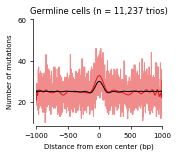

In [12]:
plot('exons_centered_3mer_CCDS.tsv', "Internal_exon_centered_CCDS.svg")

### Plot results

Binned average approach. Bin size is 25.

/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


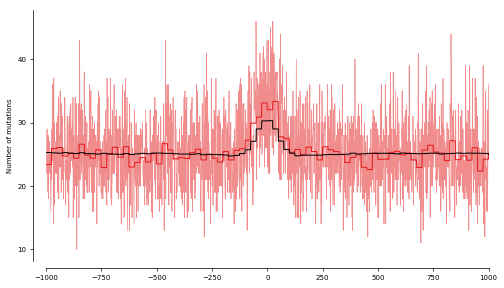

In [13]:
size = 25

listt = ['3mer_CCDS']

NROW=1
NCOL=1

axs = []

fig = plt.figure(figsize=(7,4))

for row in range(0, NROW):
    for col in range(0, NCOL):
        axs.append(plt.subplot2grid((NROW, NCOL), (row, col)))

cnt=0
for ele in listt:
    plot_HD_BINNED(ele, axs[cnt], cnt, size)
    cnt+=1
    
plt.tight_layout()
plt.savefig(path.join('figures', 'internal_exon_centered_binned_HD_CCDS.svg'), bbox_inches='tight')
plt.show()

### Plot results

Polynomial fit approach.

/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: The fit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel_launcher.py:17: RankWarning: The fit may be poorly conditioned
/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


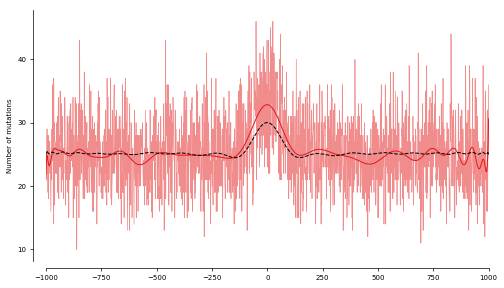

In [14]:
listt = ['3mer_CCDS']

NROW=1
NCOL=1

axs = []

fig = plt.figure(figsize=(7,4))

for row in range(0, NROW):
    for col in range(0, NCOL):
        axs.append(plt.subplot2grid((NROW, NCOL), (row, col)))

cnt=0
for ele in listt:
    plot_HD(ele, axs[cnt], cnt)
    cnt+=1
    
    
plt.tight_layout()
plt.savefig(path.join('figures', 'internal_exon_centered_HD_CCDS.svg'), bbox_inches='tight')
plt.show()